In [1]:
import torch
import torch.nn as nn
torch.manual_seed(1)
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.nn.functional import one_hot
from train import *
from model import *

In [2]:
fashion_tr = torchvision.datasets.FashionMNIST('~/.torchvision', train=True, download=True)
fashion_ts = torchvision.datasets.FashionMNIST('~/.torchvision', train=False, download=True)

# input values are normalized to [0, 1]
x_tr, y_tr = fashion_tr.data.float()/255, fashion_tr.targets
x_ts, y_ts = fashion_ts.data.float()/255, fashion_ts.targets

x_tr_cnn, y_tr_cnn = x_tr.unsqueeze(1), one_hot(y_tr)
x_ts_cnn, y_ts_cnn = x_ts.unsqueeze(1), one_hot(y_ts)
classes = fashion_tr.classes
print(x_tr_cnn.shape, y_tr_cnn.shape, x_ts_cnn.shape, y_ts_cnn.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([60000, 10]) torch.Size([10000, 1, 28, 28]) torch.Size([10000, 10])


In [3]:
def load_model_parameters(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()

100%|█████████████████████████████████████████| 20/20 [01:54<00:00,  5.71s/it, loss=0.21632, train_acc=92.76%]


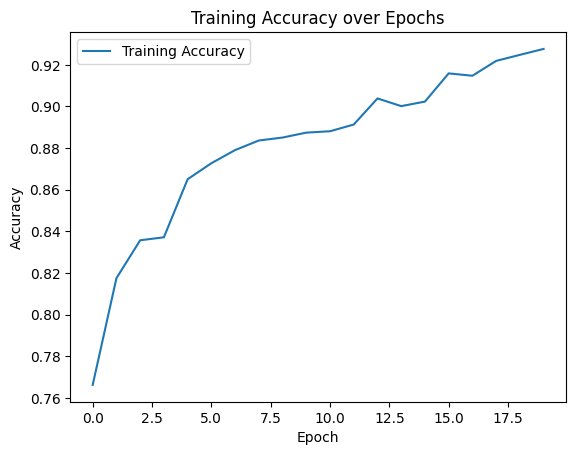

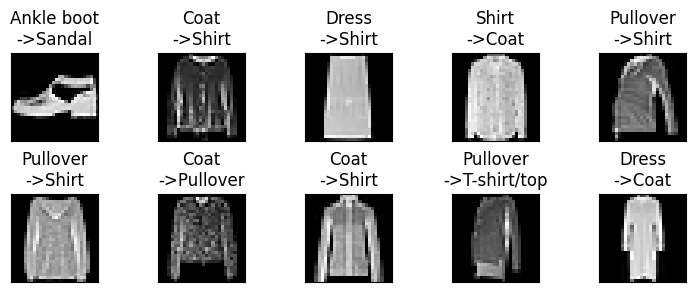

test set accuracy is: tensor(0.8892)


In [4]:
torch.manual_seed(1)
basic_model = basicCNN()
train(basic_model,x_tr_cnn, y_tr_cnn, nn.CrossEntropyLoss(), lr=0.1, batch_size=300)
print("test set accuracy is:",test(basic_model,x_ts_cnn, y_ts_cnn,showerrors=True))

In [5]:
torch.save(basic_model.state_dict(), "basicCNN.pt")


In [6]:
att_CNN = attentionCNN(attention_type="se")
print(att_CNN)

attentionCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
  (attention): SELayer(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=16, out_features=1, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1, out_features=16, bias=True)
      (3): Sigmoid()
    )
  )
)


In [7]:
CNN_state = torch.load('basicCNN.pt')

att_CNN.load_state_dict(CNN_state,strict=False)

_IncompatibleKeys(missing_keys=['attention.fc.0.weight', 'attention.fc.0.bias', 'attention.fc.2.weight', 'attention.fc.2.bias'], unexpected_keys=[])

In [8]:
torch.manual_seed(1)
new_attn = attentionCNN(attention_type="se")
print("Generate randomly",att_CNN.state_dict()["attention.fc.0.weight"])
print("Inherent weight from basic CNN",new_attn.state_dict()["attention.fc.0.weight"])
# 

Generate randomly tensor([[ 0.2127,  0.2200, -0.1763,  0.1606, -0.2405,  0.0962, -0.2058,  0.0514,
         -0.0477, -0.1928, -0.2212,  0.1415, -0.1335,  0.1284, -0.0422, -0.2469]])
Inherent weight from basic CNN tensor([[ 0.1336, -0.0136, -0.0157,  0.0783,  0.1232,  0.0207, -0.0916,  0.0720,
          0.0529, -0.0025,  0.2077, -0.0960, -0.1112, -0.1080, -0.0631, -0.0494]])


100%|█████████████████████████████████████████| 20/20 [02:11<00:00,  6.58s/it, loss=0.24402, train_acc=91.70%]


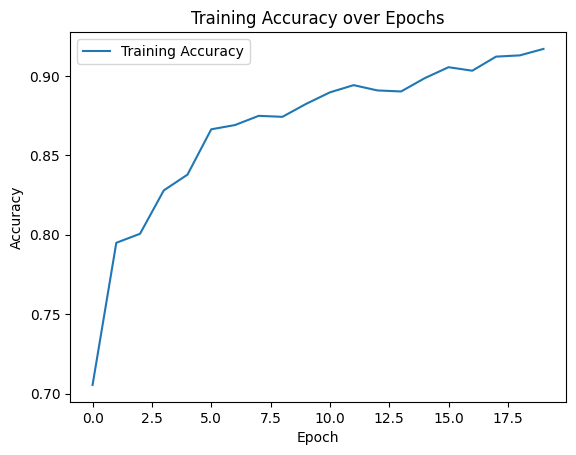

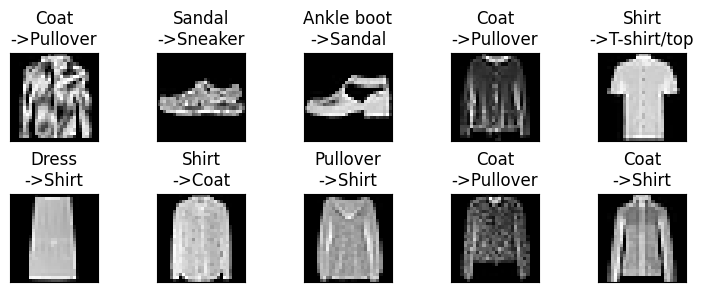

test set accuracy is: tensor(0.8847)


In [9]:
train(new_attn,x_tr_cnn, y_tr_cnn, nn.CrossEntropyLoss(), lr=0.1, batch_size=300,nepochs=20)
print("test set accuracy is:",test(new_attn,x_ts_cnn, y_ts_cnn,showerrors=True))

100%|█████████████████████████████████████████| 20/20 [02:14<00:00,  6.74s/it, loss=0.10245, train_acc=96.33%]


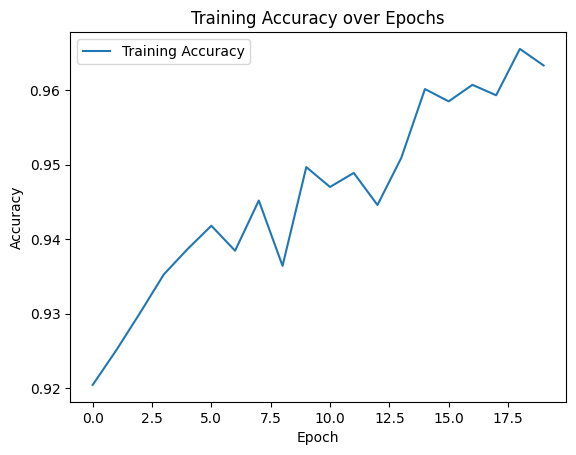

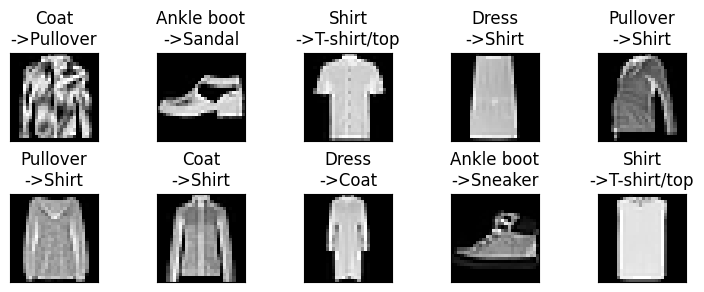

test set accuracy is: tensor(0.8946)


In [10]:

train(att_CNN,x_tr_cnn, y_tr_cnn, nn.CrossEntropyLoss(), lr=0.1, batch_size=300,nepochs=20)
print("test set accuracy is:",test(att_CNN,x_ts_cnn, y_ts_cnn,showerrors=True))

In [5]:
torch.manual_seed(1)
CNN_state = torch.load('basicCNN.pt')
new_sp_attn = attentionCNN(attention_type="spatial")
print("Generate randomly",new_sp_attn.state_dict()["attention.conv.weight"])
sp_attn = attentionCNN(attention_type="spatial") 
sp_attn.load_state_dict(CNN_state,strict=False)
print("Inherent weight from basic CNN",sp_attn.state_dict()["attention.conv.weight"])

Generate randomly tensor([[[[ 0.0540, -0.0055, -0.0063,  0.0316,  0.0498,  0.0084, -0.0370],
          [ 0.0291,  0.0214, -0.0010,  0.0839, -0.0388, -0.0449, -0.0436],
          [-0.0255, -0.0200,  0.0445, -0.0457,  0.0690,  0.0196, -0.0295],
          [-0.0425, -0.0395,  0.0679,  0.0533,  0.0280,  0.0734, -0.0642],
          [ 0.0161,  0.0591,  0.0840, -0.0950, -0.0619,  0.0853, -0.1003],
          [ 0.0672,  0.0192,  0.0862,  0.0613, -0.0071,  0.0932, -0.0170],
          [ 0.0005, -0.0854, -0.0108,  0.0300,  0.0030, -0.0467,  0.0113]],

         [[-0.0755, -0.0449,  0.0416,  0.0661, -0.0986,  0.0119, -0.0468],
          [-0.0681, -0.0019,  0.0871, -0.0046, -0.0362,  0.0047,  0.0486],
          [ 0.0003,  0.0992,  0.0101, -0.0465, -0.0919,  0.0878, -0.0210],
          [ 0.0529,  0.0826,  0.0003,  0.0294, -0.0149, -0.0544,  0.0675],
          [-0.0407,  0.0735,  0.0401, -0.0033, -0.0694,  0.0434, -0.0572],
          [ 0.0096,  0.0746, -0.0822,  0.0945,  0.0985, -0.0168,  0.0707],
     

100%|█████████████████████████████████████████| 20/20 [02:45<00:00,  8.29s/it, loss=0.21742, train_acc=92.44%]


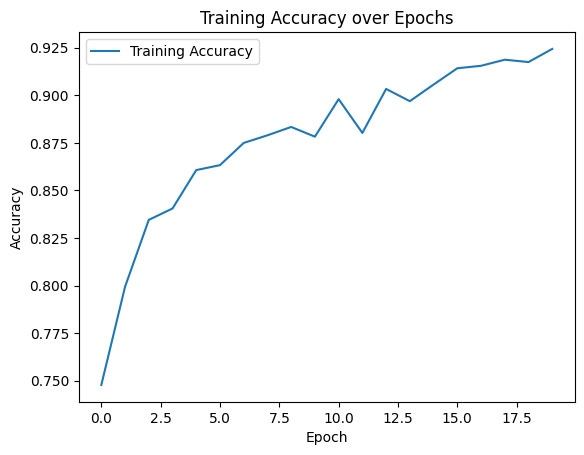

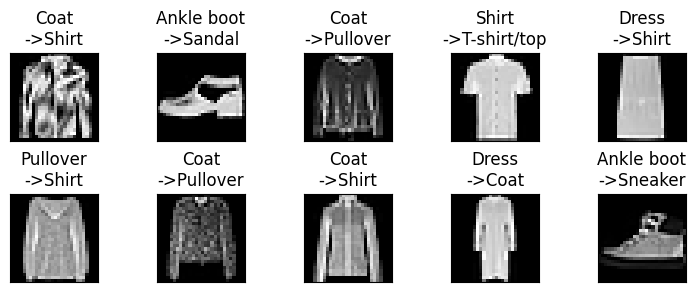

test set accuracy is: tensor(0.8922)


In [6]:
train(new_sp_attn,x_tr_cnn, y_tr_cnn, nn.CrossEntropyLoss(), lr=0.1, batch_size=300,nepochs=20)
print("test set accuracy is:",test(new_sp_attn,x_ts_cnn, y_ts_cnn,showerrors=True))

100%|█████████████████████████████████████████| 20/20 [02:47<00:00,  8.38s/it, loss=0.09033, train_acc=97.55%]


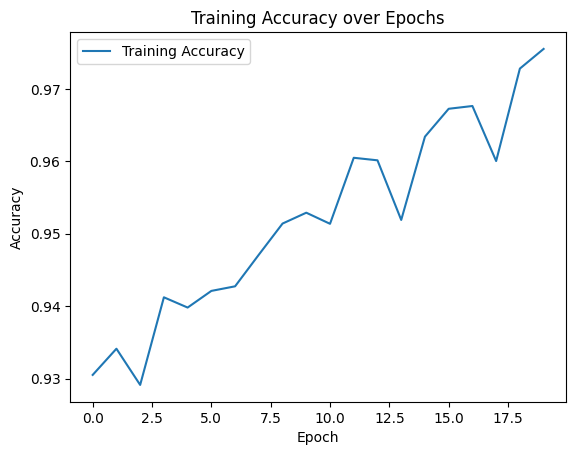

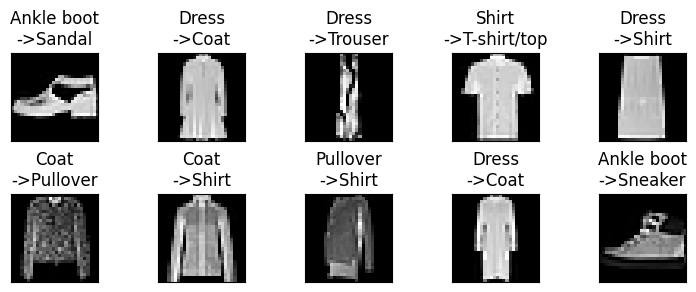

test set accuracy is: tensor(0.8979)


In [7]:
train(sp_attn,x_tr_cnn, y_tr_cnn, nn.CrossEntropyLoss(), lr=0.1, batch_size=300,nepochs=20)
print("test set accuracy is:",test(sp_attn,x_ts_cnn, y_ts_cnn,showerrors=True))

In [3]:
torch.manual_seed(1)
CNN_state = torch.load('basicCNN.pt')
new_ch_attn = attentionCNN(attention_type="channel")
print("Generate randomly",new_ch_attn.state_dict()["attention.fc.0.weight"])
ch_attn = attentionCNN(attention_type="channel") 
ch_attn.load_state_dict(CNN_state,strict=False)
print("Inherent weight from basic CNN",ch_attn.state_dict()["attention.fc.0.weight"])

Generate randomly tensor([[ 0.1336, -0.0136, -0.0157,  0.0783,  0.1232,  0.0207, -0.0916,  0.0720,
          0.0529, -0.0025,  0.2077, -0.0960, -0.1112, -0.1080, -0.0631, -0.0494]])
Inherent weight from basic CNN tensor([[-0.1201,  0.0981,  0.1825, -0.1116,  0.0552,  0.0941, -0.2199, -0.2469,
          0.1508, -0.2212, -0.2030,  0.2061, -0.0938, -0.0234, -0.1125,  0.1715]])


100%|█████████████████████████████████████████| 20/20 [02:30<00:00,  7.54s/it, loss=0.23329, train_acc=91.86%]


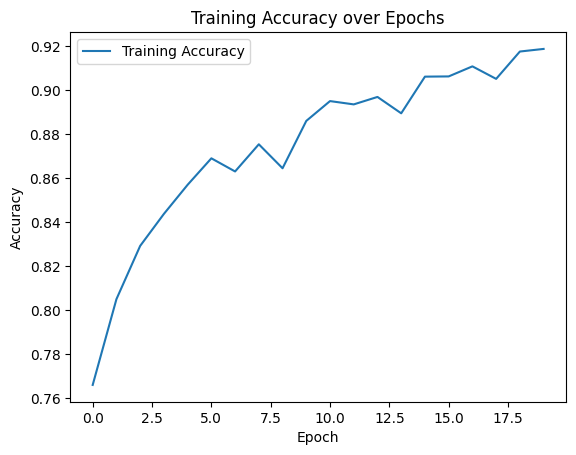

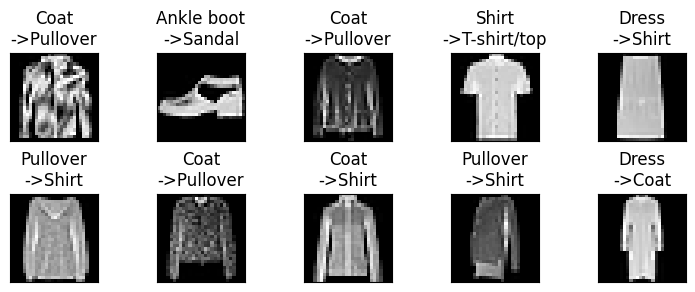

test set accuracy is: tensor(0.8899)


In [4]:
train(new_ch_attn,x_tr_cnn, y_tr_cnn, nn.CrossEntropyLoss(), lr=0.1, batch_size=300,nepochs=20)
print("test set accuracy is:",test(new_ch_attn,x_ts_cnn, y_ts_cnn,showerrors=True))

100%|█████████████████████████████████████████| 20/20 [02:34<00:00,  7.74s/it, loss=0.10068, train_acc=97.00%]


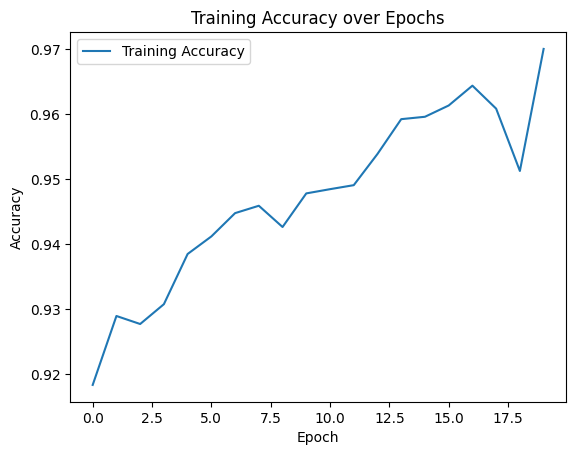

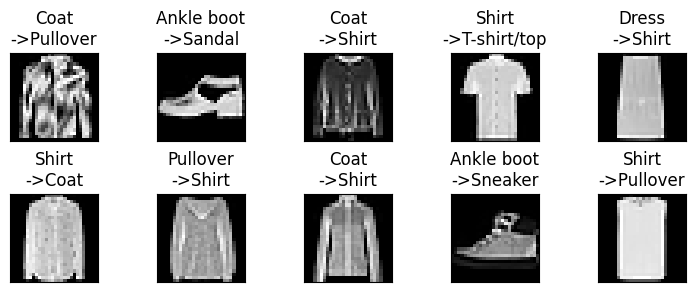

test set accuracy is: tensor(0.8957)


In [5]:
train(ch_attn,x_tr_cnn, y_tr_cnn, nn.CrossEntropyLoss(), lr=0.1, batch_size=300,nepochs=20)
print("test set accuracy is:",test(ch_attn,x_ts_cnn, y_ts_cnn,showerrors=True))

In [2]:
import torch
print(torch.rand(1,5))

tensor([[0.0139, 0.7546, 0.6694, 0.2302, 0.3787]])
